<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

Jung CHang-Young
Thierry Kunda 
Groupe 1 L2 Info

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://codalab.lisn.upsaclay.fr/competitions/3739

* **Étape 1 :** S'enregistrer sur https://codalab.lisn.upsaclay.fr

* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://codalab.lisn.upsaclay.fr/competitions/3739#participate-get_starting_kit) "Participate > Files > Public Data".

* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour la qualité de la présentation orale 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module requis : `imblearn` (à installer avec `conda`)

`conda install -c conda-forge imbalanced-learn`

In [5]:
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [6]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<span style="color:red">
    Répondre ci-dessous
</span>

On a un jeu de données sur des personnes hospitalisées.
L'objectif est de mettre en place un modèle qui permet de prédire si les patients vont survivre ou pas, en fonction des données qu'on lui a intégré.
Il s'adapte automatiquement.

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

Notre modèle lance deux types de prédictions : futur décès et (future) survie. 
Utiliser balanced_accuracy_score nous permet d'avoir une meilleur idée sur la précision et l'efficacité des deux prédictions du modèle en faisant une moyenne.
Alors que l'accuracy_score de base, calculerait simplement les prédictions de manière brute et de donner le pourcentage de réussite global.

## 2. Chargement des données

In [7]:
DATA = Path("~/Cours/ISD2/public_data").expanduser()
# DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [8]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [9]:
x_df.head(12)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,75,83.8,89.2,86.1,...,0,0,0,0,0,0,0,0,1,0
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,55,60.9,106,80.6,...,0,0,0,0,0,0,0,0,0,0
5,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,F,66,40,68.4,60.4,...,0,0,0,0,0,0,0,0,0,0
6,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,M,88,56.9,98.8,70.7,...,0,0,0,0,0,0,0,0,1,0
7,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,F,81,62,85.8,84.5,...,0,0,0,0,0,0,1,0,0,0
8,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,M,57,89.7,110,114,...,0,0,0,0,0,0,0,0,0,1
9,Medicare,ENGL,JEWISH,MARRIED,WHITE,M,90,73,102,94.1,...,0,0,0,0,0,0,1,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codalab et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [10]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

#### Types des variables

In [11]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [12]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

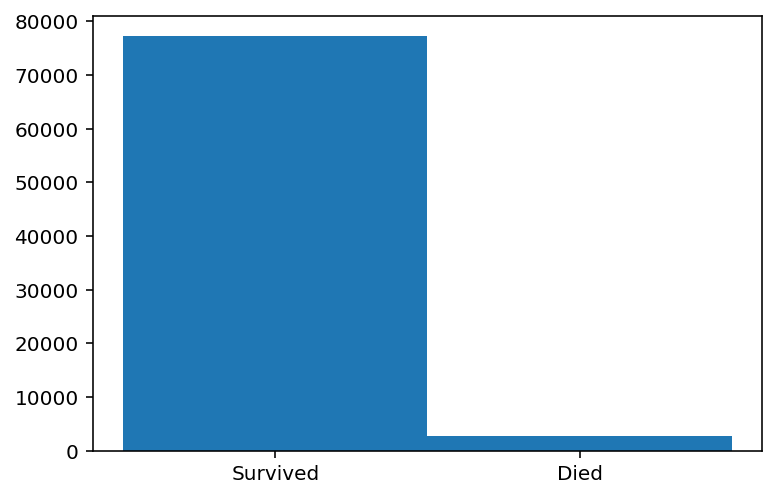

In [13]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

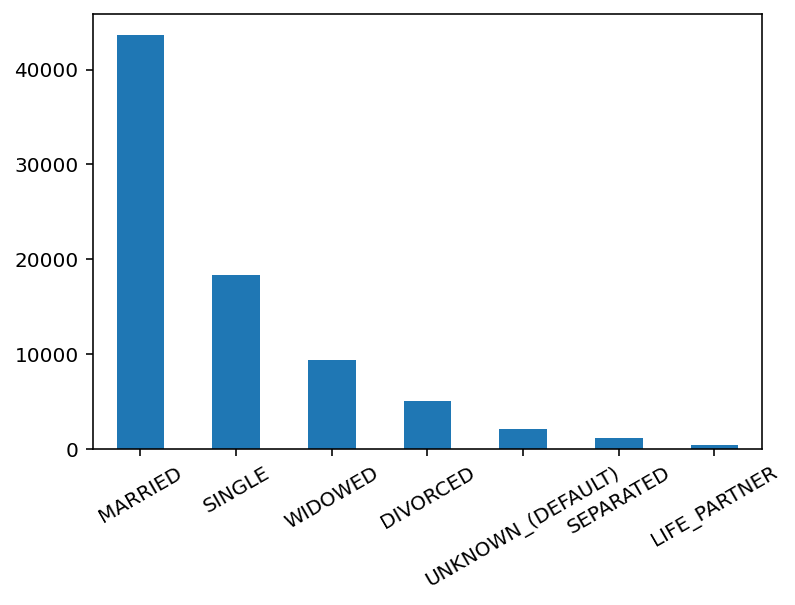

In [14]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

<span style="color:red">
    Répondre ci-dessous
</span>

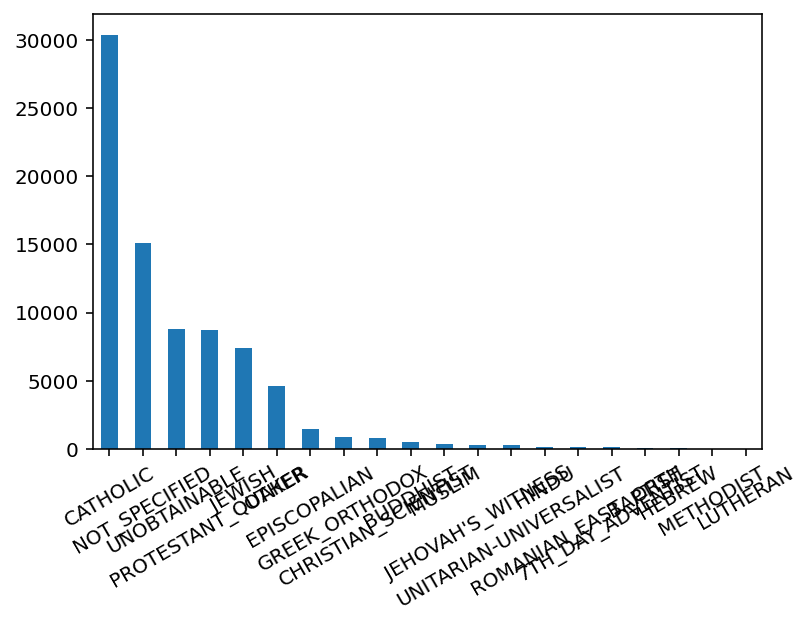

In [15]:
x_language_cnts = x_df["RELIGION"].value_counts()
x_language_cnts.plot.bar(rot = 30)
plt.show()

#### Corrélations

<AxesSubplot:>

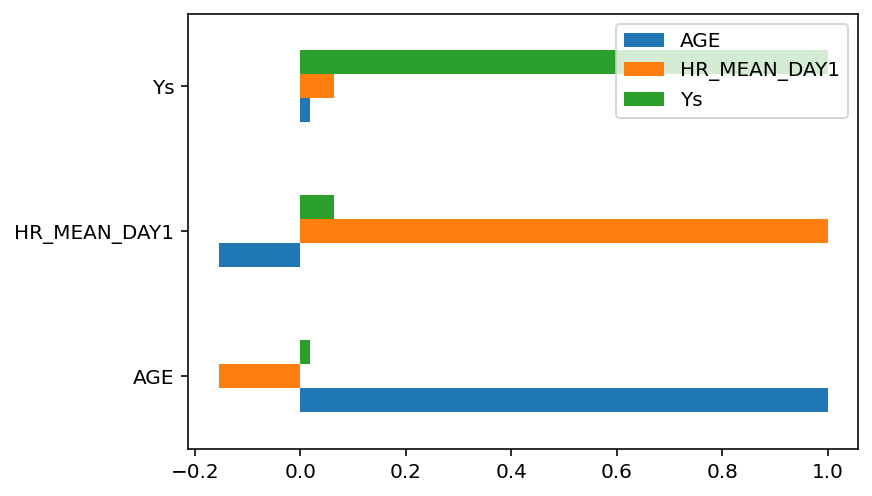

In [16]:
correl_df = pd.DataFrame({"AGE":x_df["AGE"],"HR_MEAN_DAY1":x_df["HR_MEAN_DAY1"]})
correl_df["Ys"]=ys
corr = correl_df.corr()
corr.plot.barh()


Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Le premier graphique nous montre le statut marital des 80 000 patients. On peut voir que majoritairement, les patients sont mariés.
Le deuxième graphique nous montre que les trois religions dominantes parmi les 80 000 patients sont : Le catholicisme, le judaïsme et le protestantisme.
Le dernier graphique est notre graphique de corrélation entre la variable cible y, le hr mean day1 et l'âge des patients. On peut observer des corrélations positives et négatives entre les variables. On peut voir par exemple que pour l'âge, on se rapproche de -0,2 lorsqu'on teste sa corrélation avec HR_MEAN_DAY1

#### Autres graphiques ou résultats d'une analyse exploratoire

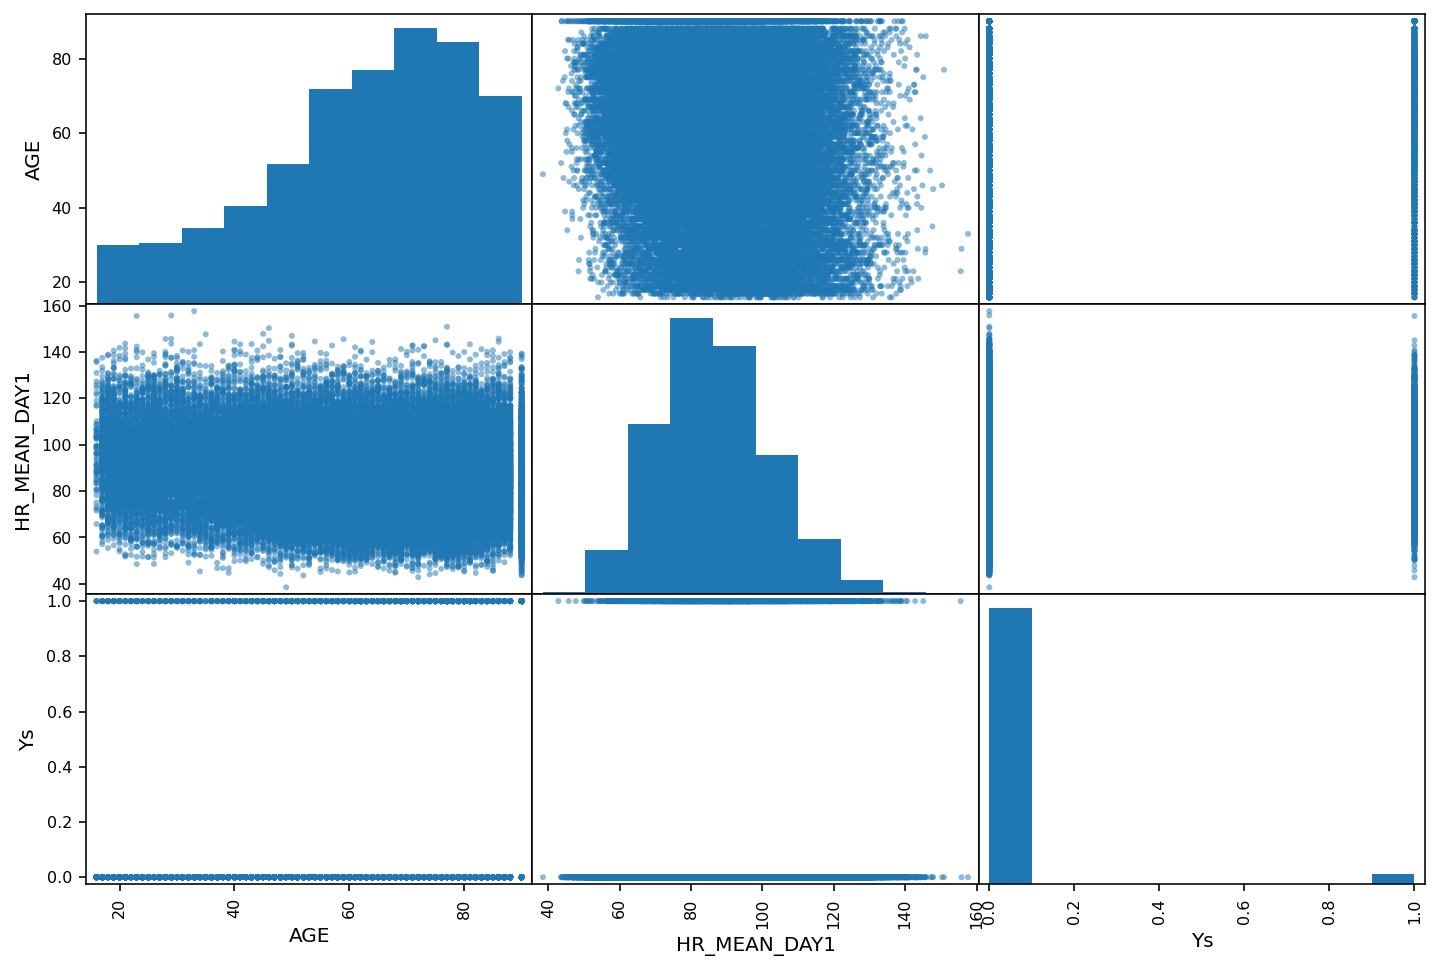

In [17]:
pd.plotting.scatter_matrix(correl_df, figsize =(12,8))
plt.show()


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Dans notre scatter matrix, on peut voir des corrélations positives avec HR_MEAN_DAY1 et Age 

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [18]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [19]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [20]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [21]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [22]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [23]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

False
False


In [24]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Gestion des catégories rares

Simplifiez les données en regroupant par exemple les catégories rares.

In [25]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object')
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: RELIGION, dtype: int64


#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [26]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="LANGUAGE", keep_n=5)
print(x_test_df["LANGUAGE"].value_counts())

Index(['ENGL', 'SPAN', 'RUSS', 'PTUN', 'CANT'], dtype='object')
ENGL     18883
OTHER      485
SPAN       258
RUSS       151
PTUN       147
CANT        77
Name: LANGUAGE, dtype: int64


### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [27]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [28]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [30]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [31]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [32]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,4,0,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

In [33]:
codes, uniques = pd.factorize(x_df["MARITAL_STATUS"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

{'DIVORCED': 0,
 'SINGLE': 1,
 'WIDOWED': 2,
 'MARRIED': 3,
 'UNKNOWN_(DEFAULT)': 4,
 'SEPARATED': 5,
 'LIFE_PARTNER': 6}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [34]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_oh_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_oh_df = x_all_oh_df.iloc[: len(x_df)].copy()
x_test_oh_df = x_all_oh_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_oh_df.shape, x_test_oh_df.shape)

(79999, 337) (20001, 337)
(79999, 401) (20001, 401)


#### Suppression des variables à valeur unique (constantes)

In [38]:
const_cols = {col for col in x_oh_df if len(x_oh_df[col].unique()) == 1}
len(const_cols)

0

In [39]:
x_oh_df.drop(const_cols, axis="columns", inplace=True)
x_test_oh_df.drop(const_cols, axis="columns", inplace=True)

print(x_oh_df.shape, x_test_oh_df.shape)

(79999, 228) (20001, 228)


### Création de l'ensemble de validation

In [40]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_oh_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_oh_df

### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [41]:
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(x_oh_df)
pca = decomposition.PCA(n_components = 30)
x_pca = pca.fit_transform(scaled_data)
x_pca


array([[-3.774, -0.572, -1.56 , ..., -0.145, -0.266,  0.327],
       [-0.173,  0.202, -2.117, ...,  0.194,  0.489,  1.23 ],
       [ 8.526,  9.987, -2.2  , ..., -1.843, -9.29 , -0.164],
       ...,
       [ 0.52 , -4.684, -0.384, ..., -0.919,  1.379,  0.806],
       [ 1.075,  1.628, -2.008, ..., -2.034,  0.264, -0.162],
       [ 3.118,  4.566, -1.063, ...,  0.513,  0.414, -1.198]])

Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

Text(0, 0.5, 'Second principle component')

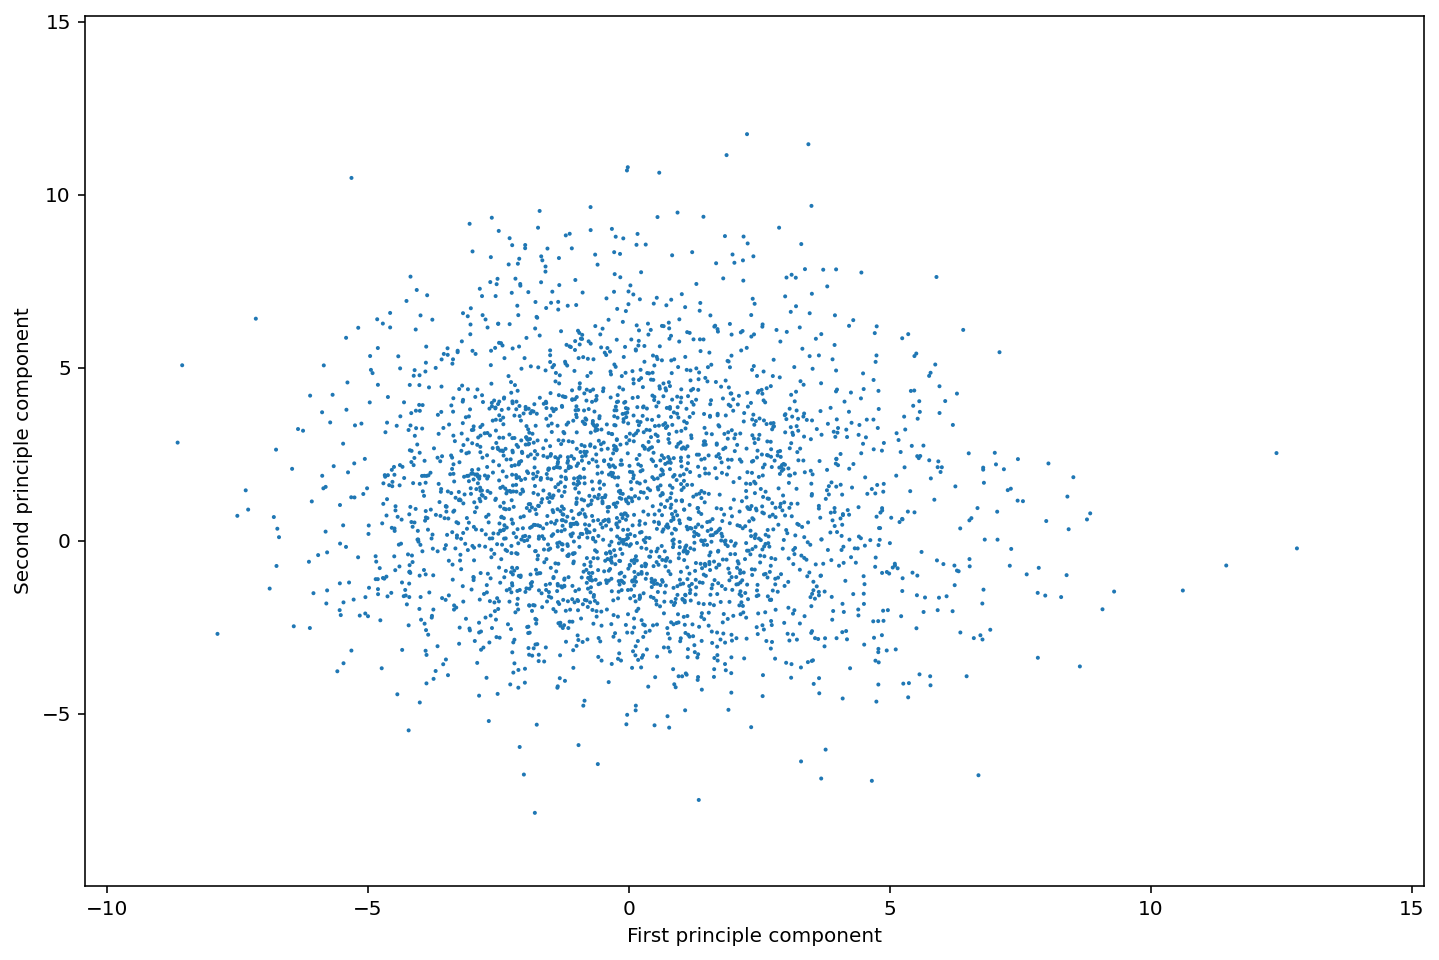

In [42]:
plt.figure(figsize=(12,8))
plt.scatter(x_pca[:,0],x_pca[:,1],ys)
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

On peut voir un nuage de points assez dispersé.

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

On peut voir un nuage de points assez dispersé. Nous avons pris la version encodée de notre fichier de patients et l'avons combiné avec la variable cible y. Notre nuage de points est horizontale, ses vecteurs sont parallèles et perpendiculaires aux axes x et y.

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [43]:
SCORINGS = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [44]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#model = linear_model.LogisticRegression(max_iter=100)
#model = ensemble.RandomForestClassifier(n_estimators=10)
#model = GaussianNB()
model = DecisionTreeClassifier()
#model = KNeighborsClassifier()




model.fit(x_train, y_train)  # training

DecisionTreeClassifier()

## 6. Évaluations

In [45]:
y_pred = model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")
y_valid.value_counts()

Balanced accuracy score: 0.524


0    23143
1      857
dtype: int64

### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [50]:
CV = 5
SCORING = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [51]:
val = model_selection.cross_val_score(model,x_train, y_train, scoring = SCORING, cv = CV)
print(val)

[0.522 0.524 0.523 0.543 0.534]


* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

<span style="color:red">
    Répondre ci-dessous
</span>

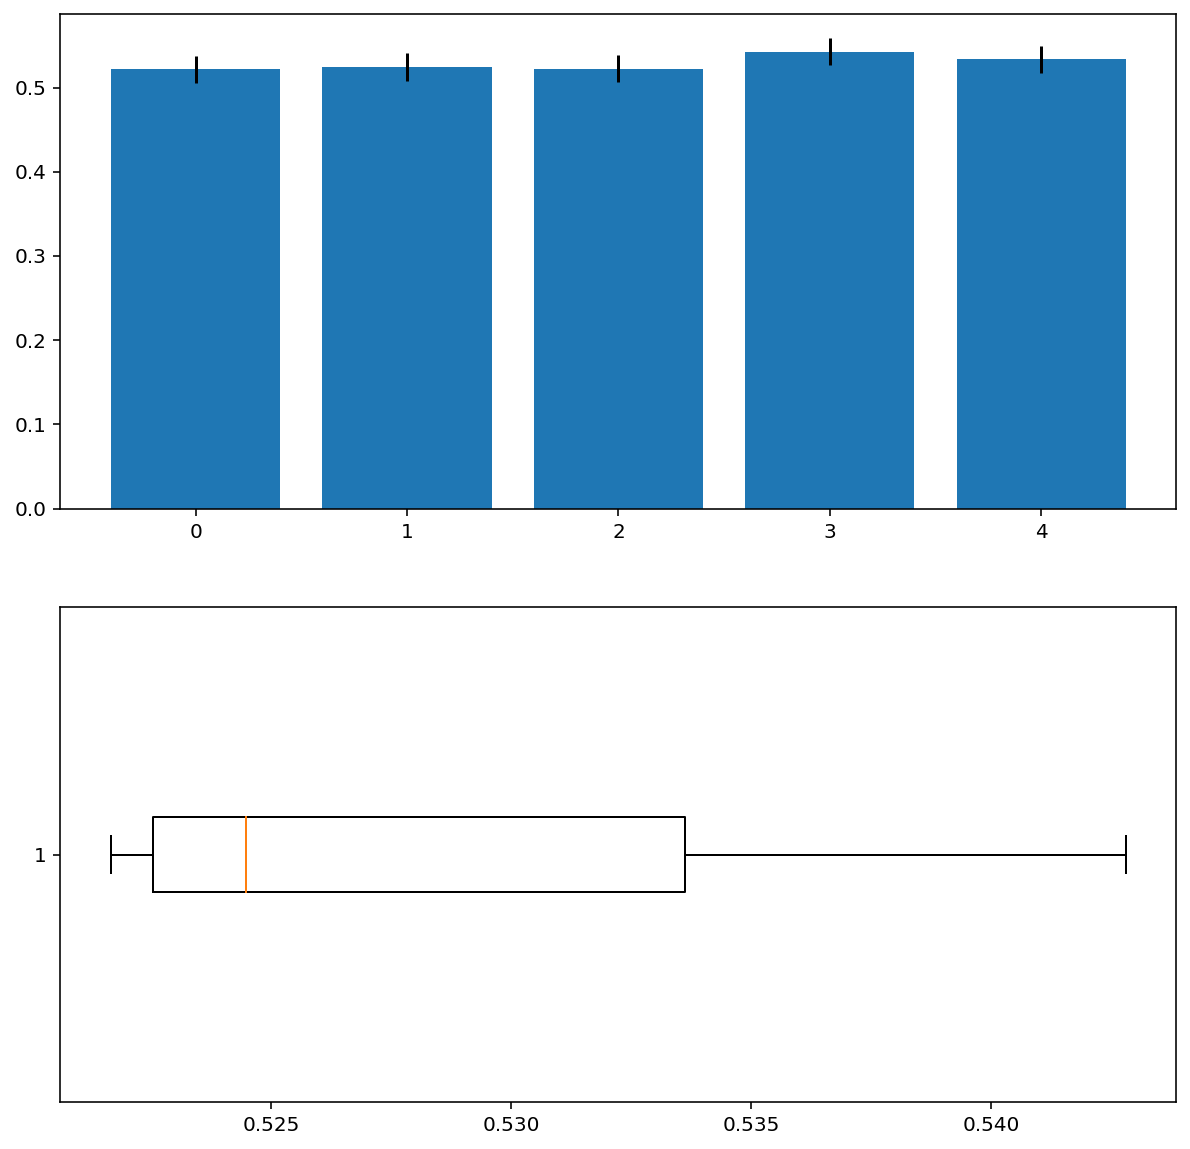

In [52]:
x = [i for i in range(len(val))]
plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(211)
plt.bar(x, val, yerr =(2*val.std()))
plt.subplot(212)
plt.boxplot(val, vert = False)
plt.show()
#DecisionTreeClassifier meilleur résultat que LogisticRegression

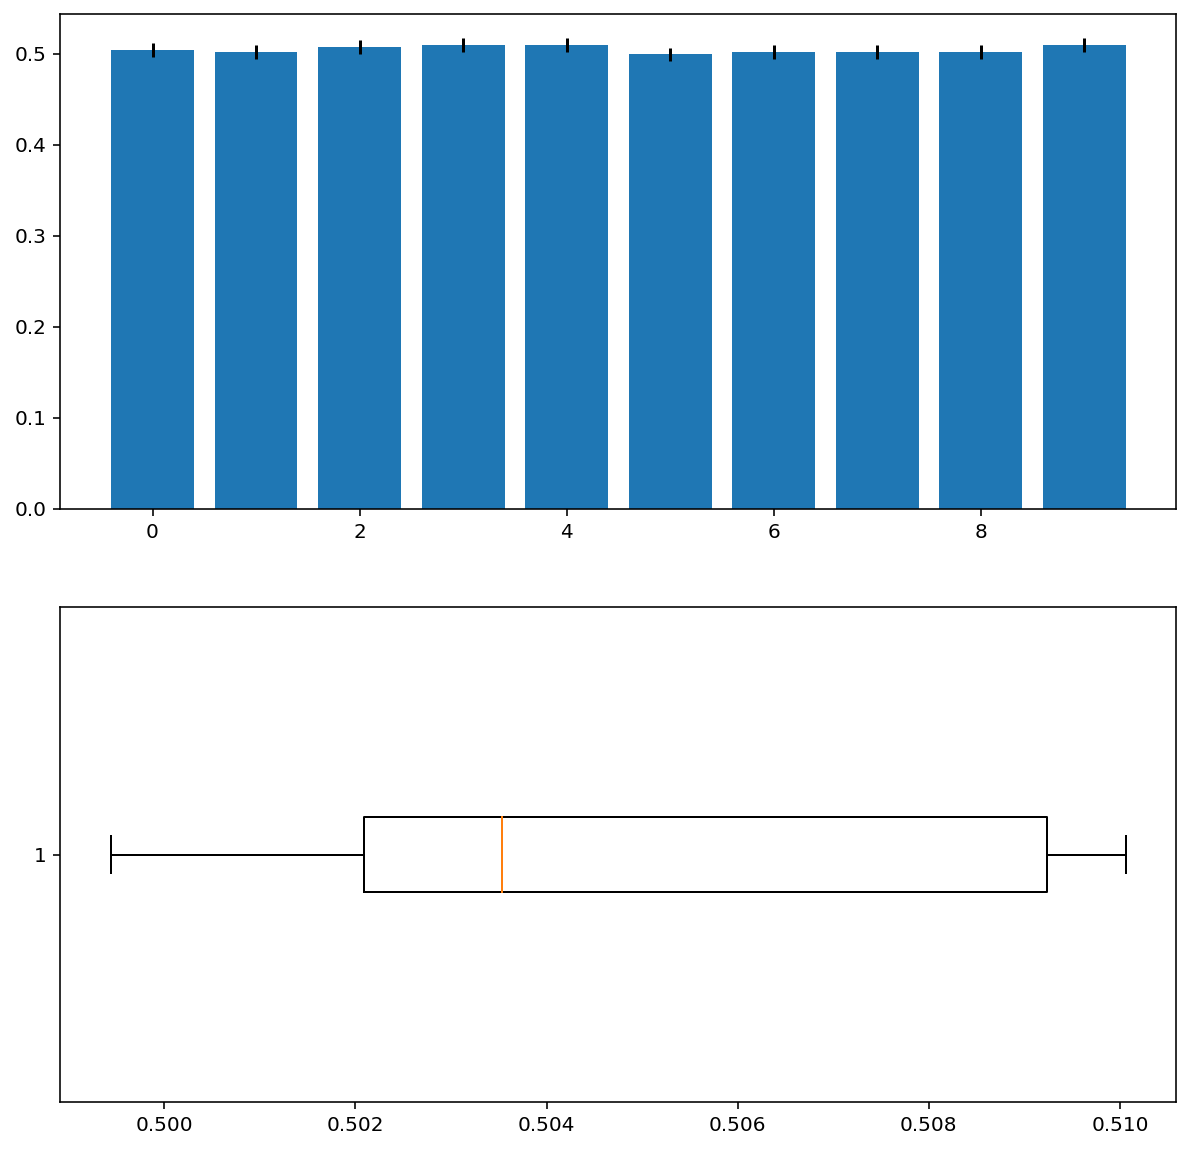

In [79]:
x = [i for i in range(len(val))]
plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(211)
plt.bar(x, val, yerr =(2*val.std()))
plt.subplot(212)
plt.boxplot(val, vert = False)
plt.show()
#LogicRegression

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

On a choisi deux modèles : LogisticRegression et DecisionTreeClassifier. On peut voir d'après les scores obtenus que le modèle DTC convient le plus car son balanced accuracy score (0.539) est supérieur à celui de LogicRegression()(0.503).  

On a representé l'ensemble des 10 scores obtenus. On a fait un histogramme avec en abscisse les 10 bâtons de scores et en ordonnée la valeur des scores.
Le deuxième graphique représente la distribution générale des valeurs avec une barre d'erreur égale à 2 fois l'écart type inclus.
En comparant les graphiques des deux modèles, on peut confirmer une plus grande efficacité de la part de DecisionTreeClassifier.

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

<span style="color:red">
    Répondre ci-dessous
</span>

In [53]:
metrics.roc_auc_score(y_valid,model.predict(x_valid)) #DecisionTreeClassifier

0.5243349766262229

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

L'air sous la courbe ROB obtenue est de 0.5391675687269388. On peut dire qu'il dépasse certaines valeurs d'hyperparamètres mais ce n'est clairement pas le meilleur résultat. (0.545). L'air sous la courbe ROC est aussi à peu près égal au résultat obtenu lors de l'évaluation.

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

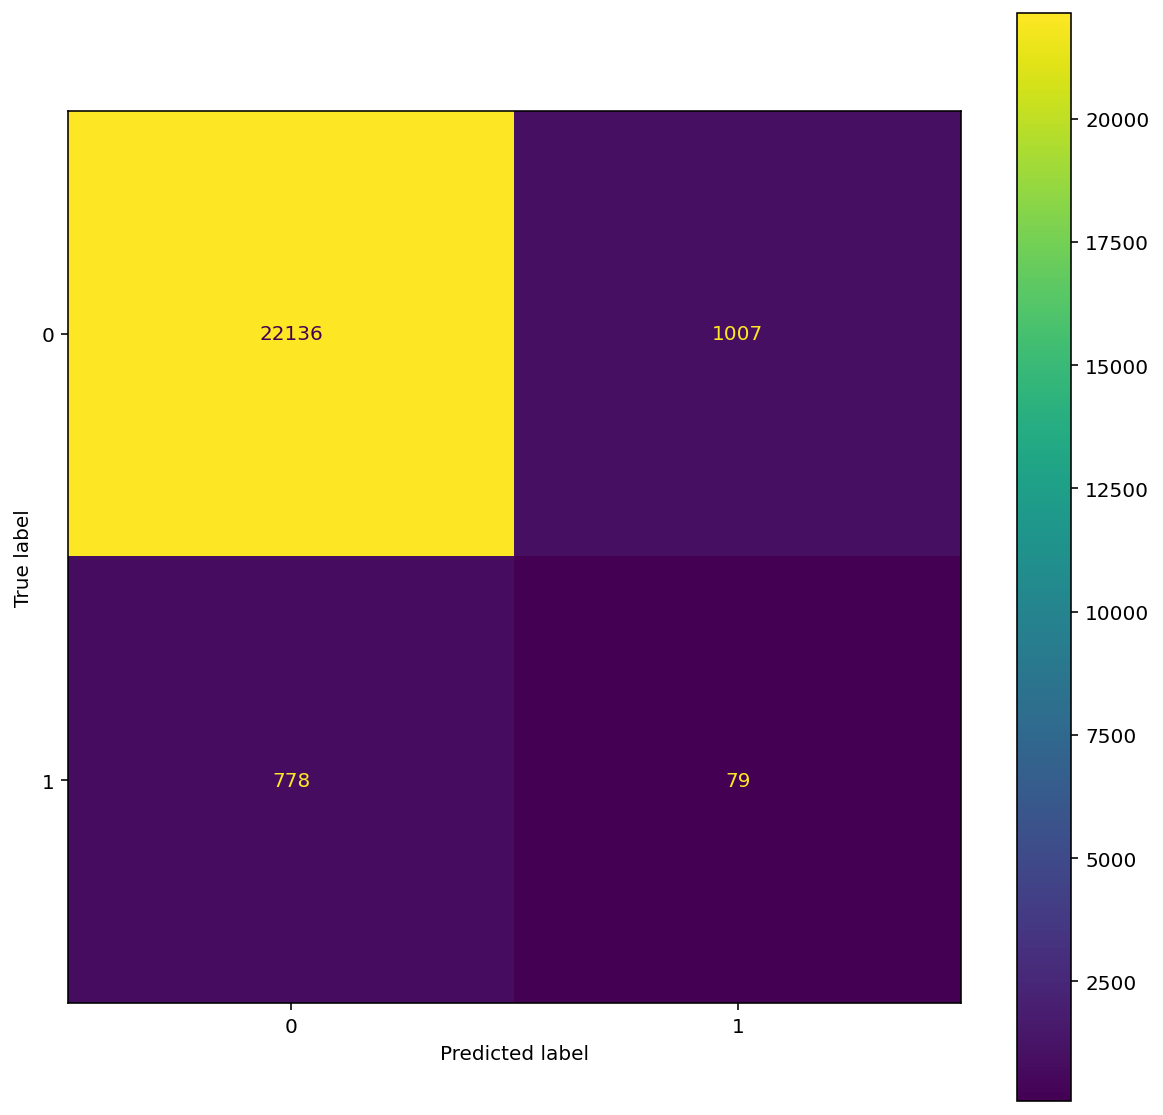

In [54]:
cm = metrics.confusion_matrix(y_valid,y_pred,labels = model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot() #DecisionTreeClassifier

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Dans notre matric de confusion, on a 4 valeurs (elle synthétise les prédictions créées par le modèle ):
- true positive : 22207
- false positive : 725
- true négative : 969
- false négative : 99
Sensitivity = 22207/(22207 + 725) = 0.9683847898
Specificity = 99/(99 + 969) = 0.0926966292
Balanced accuracy = (Sensitivity + Specificity)/2 = 0.5305407095



### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [55]:
# TODO: Data augmentation

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)

In [56]:
pipe.fit(x_train, y_train)
pipe.score(x_valid,y_valid) #Score élevé

0.8332083333333333

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé : 

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

Le meilleur résultat qu'on a obtenu est 0.545. Mais on obtient un résultat final d'environ 0.53... avec DecisionTreeClassifier

Il y a des modèles qui n'ont pas fonctionné car on utilisait de mauvais types de variables. KNeighborsClassifier n'a pas marché. Dans d'autres modèles, on a du réduire l'itération, par exemple avec le LogisticRegression.
Les autres modèles écrits plus haut en commentaires ont tous marché mais ils ne nous ont pas donné un résultat satisfaisant. 



Certains modèles ont mis peut de temps à charger (environ 30 secs), alors que pour DecisionTreeClassifier, cela a duré 3m30. LogisticRegression a en paramètre le nombre d'itérations à effectuer, donc sa durée d'entrainement dépend de son nombre d'itérations. Après des tests, la durée d'entrainement peut très bien aller de quelques secondes à une dizaine de minutes.

Si nous avions eu plus de temps, nous aurions testé plus de modèles, optimiser notre code et essayer d'autres méthodes que nous n'avons pas vu en TP ou qui ont été brièvement introduit lors des cours. Nous aurions aussi pu choisir d'autres types de données et les manipuler avec les différentes parties du projet pour une meilleure inspiration car nous savons que notre résultat obtenu n'est malheureusement pas le plus élevé. 





### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 
 Le suréchantillonnage dans l'analyse des données est une technique utilisée pour ajuster la distribution des classes d'un ensemble de données 

* En quoi pourrait-il être utile dans ce problème ?
Il peut utile car les données utilisées n'ont pas été collectées par enquête, entretien ou autre. Il nous permettrait d'introduire un biais pour séléctionner plus d'échantillons d'une classe que d'une autre, pour compenser des déséquilibres observables ou qui sont capables de se développer à cause de l'aléatoire.

<span style="color:red">
    Répondre ci-dessous
</span>

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_oh_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [115]:
predictions = model.predict(x_test_oh_df)  # compute predictions
VARS = x_test_df, x_test_fact_df, x_test_oh_df
Models = model


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions\submission_2022-04-19T01-04-50.zip


C:\Users\cjung\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---